# Loading Packages

In [216]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# Visualize Data

In [217]:
SOURCE_FILE='data/AAPL.csv'
# SOURCE_FILE='data/AMZN.csv'
# SOURCE_FILE='data/GOOG.csv'
# SOURCE_FILE='data/META.csv'
# SOURCE_FILE='data/NFLX.csv'
# SOURCE_FILE='data/TSLA.csv'

In [218]:

dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
stock_data = pd.read_csv(SOURCE_FILE,sep=',', index_col='Date', parse_dates=['Date'], date_parser=dateparse).fillna(0)
stock_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-10-15,55.290001,55.457500,54.317501,54.340000,52.351990,123164000
2018-10-16,54.732498,55.747501,54.189999,55.537498,53.505672,116736000
2018-10-17,55.575001,55.660000,54.834999,55.297501,53.274460,91541600
2018-10-18,54.465000,54.935001,53.250000,54.005001,52.029240,130325200
2018-10-19,54.514999,55.314999,54.357498,54.827499,52.821644,132314800
...,...,...,...,...,...,...
2022-10-10,140.419998,141.889999,138.570007,140.419998,140.419998,74899000
2022-10-11,139.899994,141.350006,138.220001,138.979996,138.979996,77033700
2022-10-12,139.130005,140.360001,138.160004,138.339996,138.339996,70433700


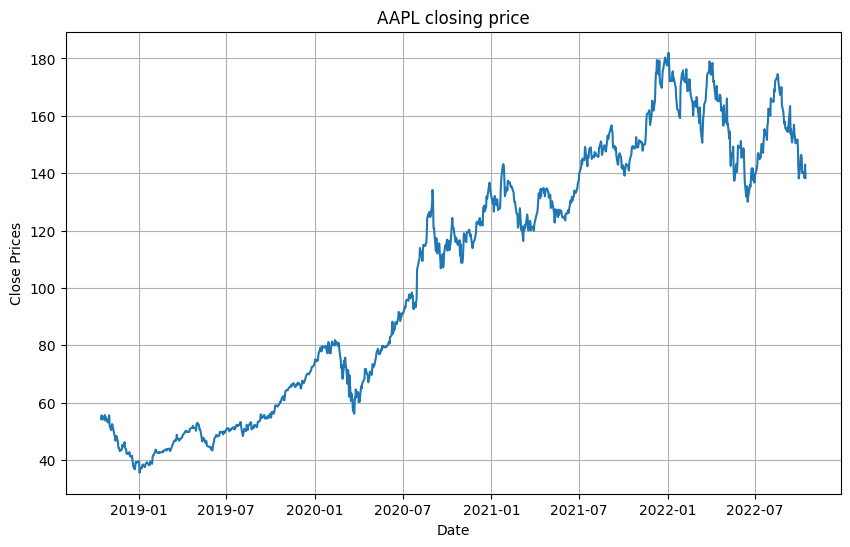

In [219]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data['Close'])
plt.title('AAPL closing price')
plt.show()

## Visualize Distribution

<AxesSubplot: ylabel='Density'>

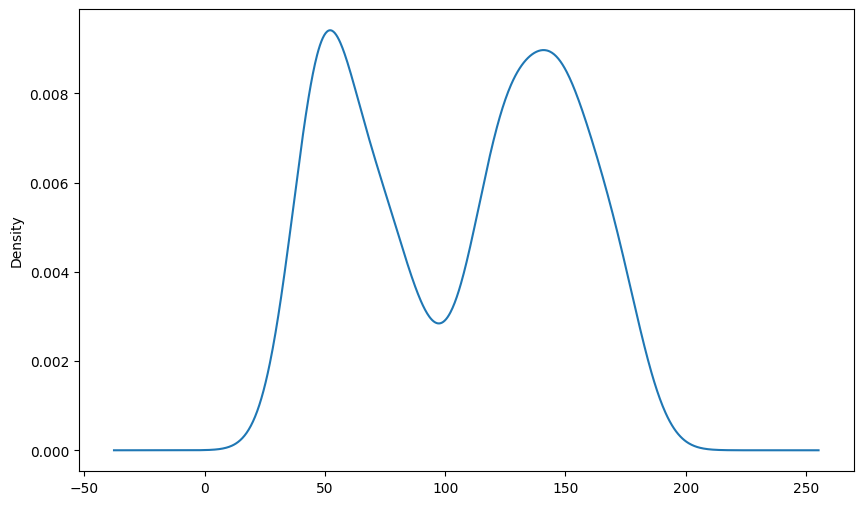

In [220]:
#Distribution of the dataset
df_close = stock_data['Close']
df_close.plot(kind='kde')

# Pre-processing

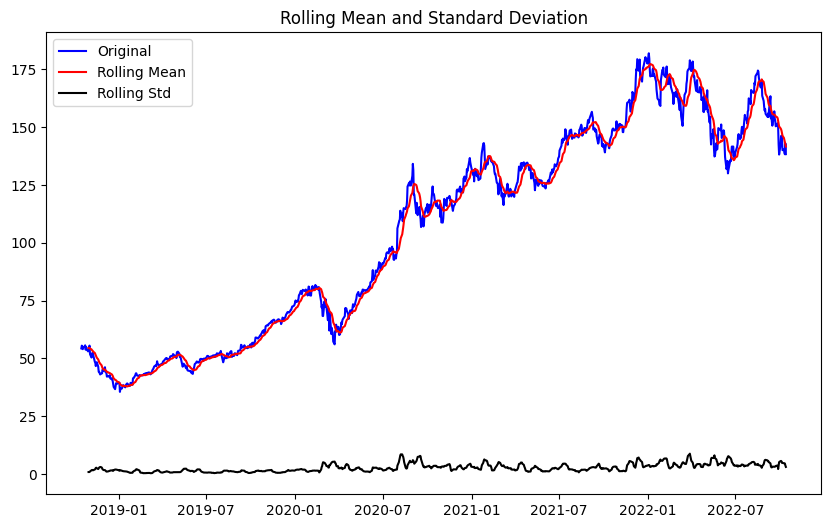

Results of dickey fuller test
Test Statistics                 -1.093506
p-value                          0.717655
No. of lags used                11.000000
Number of observations used    996.000000
critical value (1%)             -3.436933
critical value (5%)             -2.864446
critical value (10%)            -2.568317
dtype: float64


In [221]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(df_close)

<Figure size 1000x600 with 0 Axes>

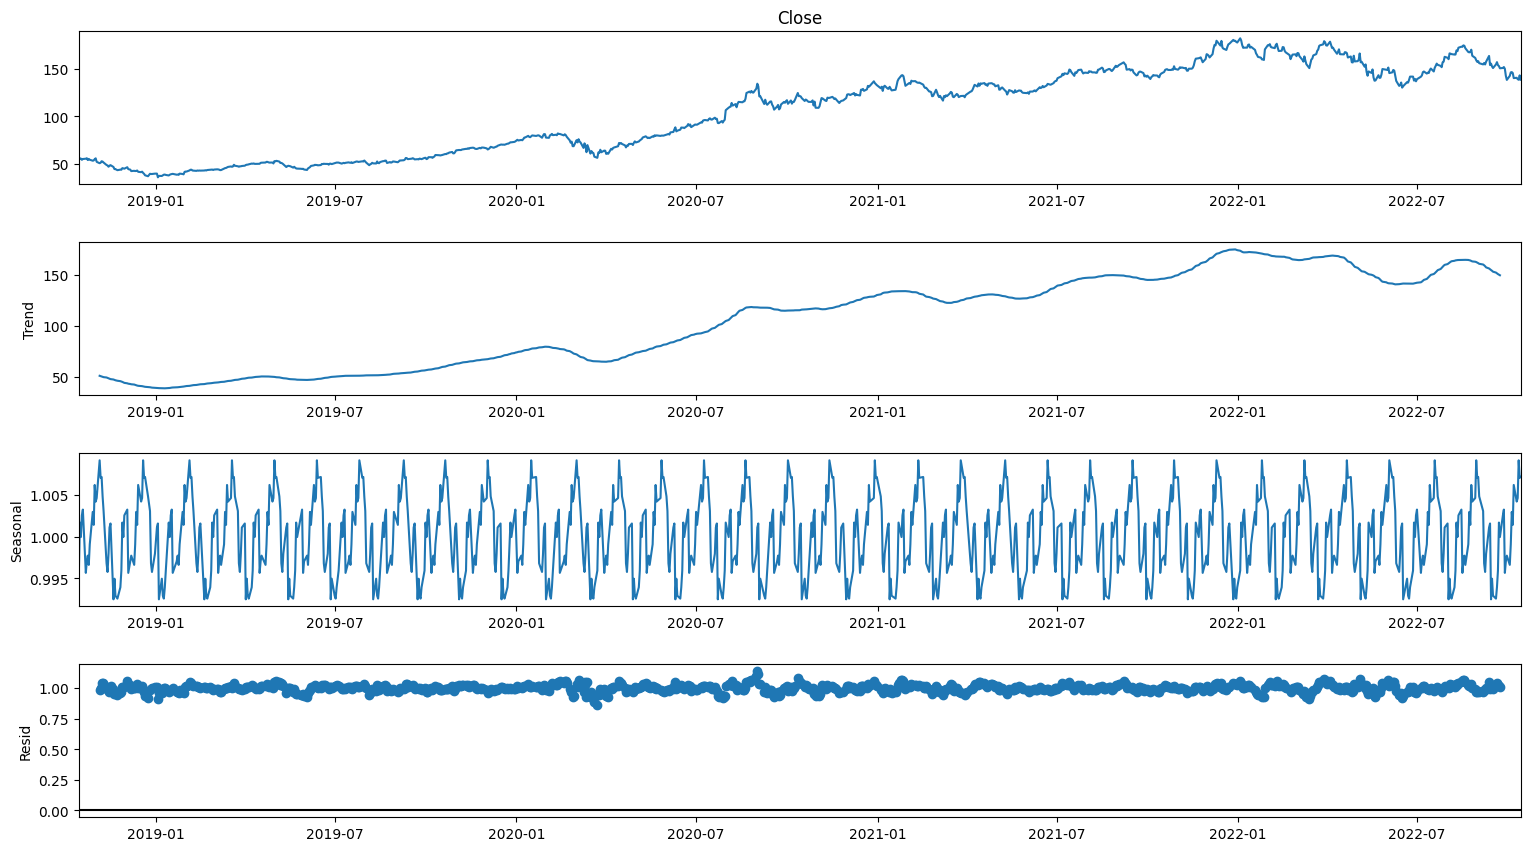

In [222]:
result = seasonal_decompose(df_close, model='multiplicative', period = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


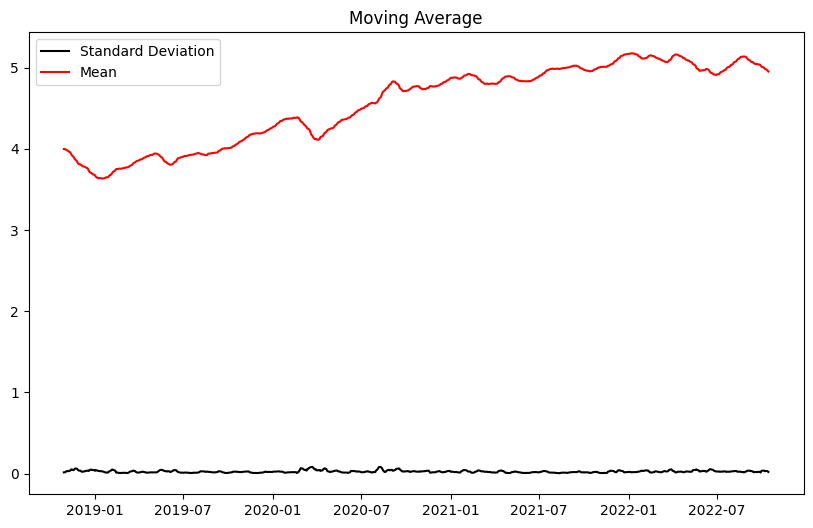

In [223]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

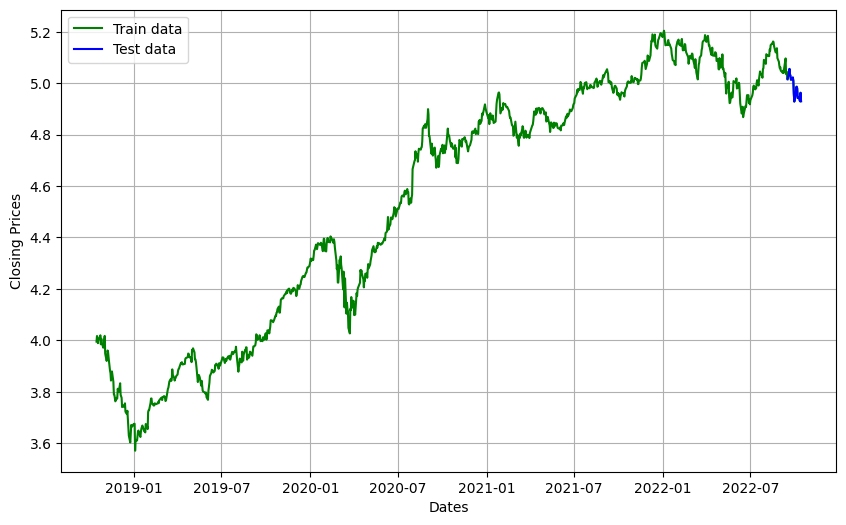

In [224]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.98)], df_log[int(len(df_log)*0.98):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [229]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=10, max_q=10, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-4722.743, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-4739.436, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-4738.900, Time=0.22 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-4722.455, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-4737.500, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-4737.525, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-4735.472, Time=0.19 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-4738.424, Time=0.05 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 0.798 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  984
Model:               SARIMAX(1, 1, 0)   Log Likelihood                2372.718
Date:                Tue, 08 Nov 2022   AIC                          -4739.436
Time:                       

KeyboardInterrupt: 

In [226]:
#Modeling
# Build Model
model = ARIMA(train_data, order=(1,1,0))  
fitted = model.fit()  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  984
Model:                 ARIMA(1, 1, 0)   Log Likelihood                2371.212
Date:                Tue, 08 Nov 2022   AIC                          -4738.424
Time:                        22:47:30   BIC                          -4728.643
Sample:                             0   HQIC                         -4734.704
                                - 984                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1347      0.021     -6.450      0.000      -0.176      -0.094
sigma2         0.0005   1.28e-05     36.654      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.00   Jarque-

In [227]:
# Forecast
# fc, se, conf = fitted.forecast(321, alpha=0.05)  # 95% conf
forecast = fitted.get_forecast(len(test_data.index))
fc = forecast.predicted_mean
conf = forecast.conf_int(alpha=0.05)

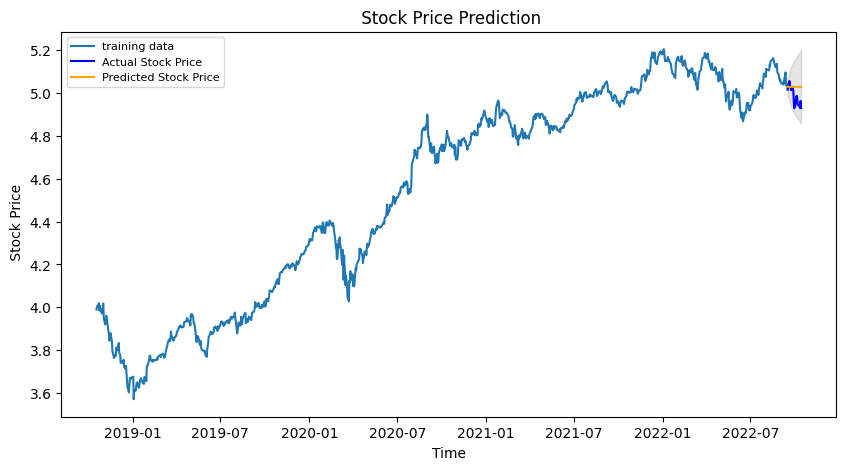

In [228]:
# Make as pandas series
fc_series = pd.Series(fc.to_numpy(), index=test_data.index)
lower_series = pd.Series(conf.to_numpy()[:, 0], index=test_data.index)
upper_series = pd.Series(conf.to_numpy()[:, 1], index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title(' Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(' Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()